In [ ]:
!kaggle datasets download -d kmader/mias-mammography

 92% 287M/312M [00:03<00:00, 99.5MB/s]
100% 312M/312M [00:03<00:00, 90.2MB/s]


In [ ]:
!unzip 'mias-mammography'

Archive:  mias-mammography.zip
  inflating: Info.txt                
  inflating: all-mias.tar.gz         
  inflating: all-mias/Info.txt       
  inflating: all-mias/Licence.txt    
  inflating: all-mias/README         
  inflating: all-mias/mdb001.pgm     
  inflating: all-mias/mdb002.pgm     
  inflating: all-mias/mdb003.pgm     
  inflating: all-mias/mdb004.pgm     
  inflating: all-mias/mdb005.pgm     
  inflating: all-mias/mdb006.pgm     
  inflating: all-mias/mdb007.pgm     
  inflating: all-mias/mdb008.pgm     
  inflating: all-mias/mdb009.pgm     
  inflating: all-mias/mdb010.pgm     
  inflating: all-mias/mdb011.pgm     
  inflating: all-mias/mdb012.pgm     
  inflating: all-mias/mdb013.pgm     
  inflating: all-mias/mdb014.pgm     
  inflating: all-mias/mdb015.pgm     
  inflating: all-mias/mdb016.pgm     
  inflating: all-mias/mdb017.pgm     
  inflating: all-mias/mdb018.pgm     
  inflating: all-mias/mdb019.pgm     
  inflating: all-mias/mdb020.pgm     
  inflating: all-mi

In [ ]:
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random # for visualization
print('Libraries Imported')

Libraries Imported


In [ ]:
path = 'all-mias/'

## Read Data

In [ ]:
import pandas as pd

print("reading dataframe")
info=pd.read_csv("Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)

reading dataframe


In [ ]:
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [ ]:
info.dropna(subset = ["SEVERITY"], inplace=True)

info.reset_index(inplace = True)
info

,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,5,mdb005,F,CIRC,B,500.0,168.0,26.0
4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
...,...,...,...,...,...,...,...,...
118,281,mdb274,F,MISC,M,127.0,505.0,123.0
119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
120,319,mdb312,F,MISC,B,240.0,263.0,20.0
121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [ ]:
info = info.drop([3], axis=0)
info.reset_index(inplace = True)
info

,level_0,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
4,5,12,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...,...,...
117,118,281,mdb274,F,MISC,M,127.0,505.0,123.0
118,119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
119,120,319,mdb312,F,MISC,B,240.0,263.0,20.0
120,121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [ ]:
# taking the images filenames in to dictionary
ids = {}
for i in range(len(info)):
    ids[i] = info.REFNUM[i]
#ids

## Turning our outputs B-M to 1-0

In [ ]:
import numpy as np

# Turning our outputs B-M to 1-0
label = []
for i in range(len(info)):
    if info.SEVERITY[i] == 'B':
        label.append(1)
    else:
        label.append(0)

In [ ]:
label = np.array(label)

In [ ]:
label.shape

(122,)

In [ ]:
# define the every images filepaths in to list
img_name = []

for i in range(len(label)):
        img_name.append(path + info.REFNUM[i]+ '.pgm')

In [ ]:
img_name = np.array(img_name)

In [ ]:
#print(img_name)
print(f'image addres amount {img_name.shape}')

image addres amount (122,)


## view image random images

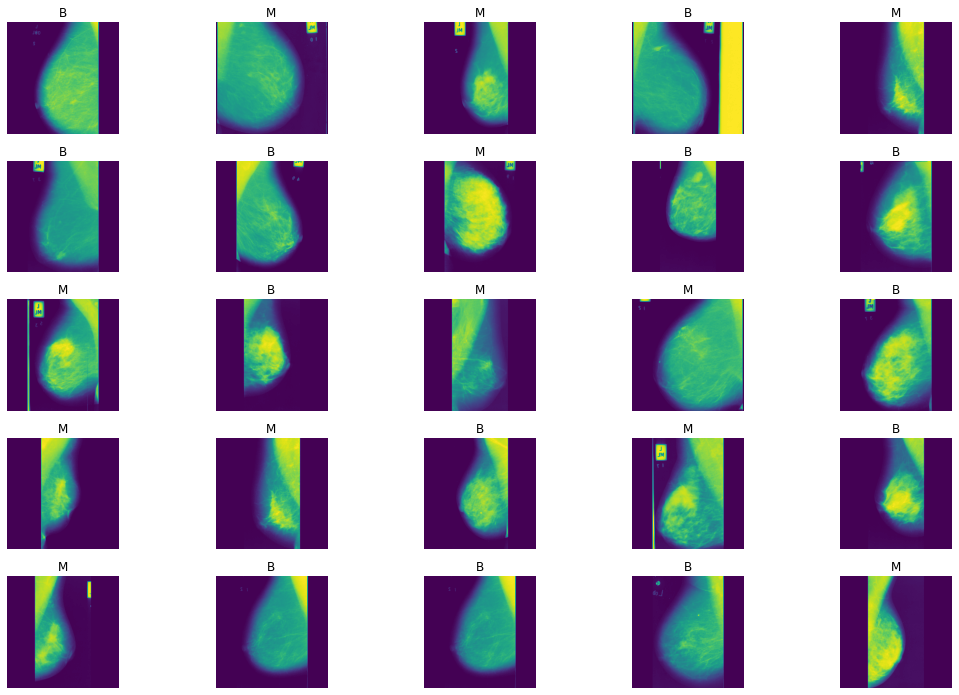

In [ ]:
# view image random images
def view_25_random_image():
    fig = plt.figure(figsize = (15, 10))
    for i in range(25):
        rand = random.randint(0,len(label))
        ax = plt.subplot(5, 5, i+1)
    
        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 1:
            plt.title('B')
        else:
            plt.title('M')
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img)
    fig.savefig('random_25_image_fig.png')

random_images = view_25_random_image()

## read Images and labels. and augmentation of images

In [ ]:
img_path = []
last_label = []
for i in range(len(img_name)):
    
    img = cv2.imread(img_name[i], 0)
    img = cv2.resize(img, (224,224))
    rows, cols= img.shape
    for angle in range(360):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (224, 224))
            img_path.append(img_rotated)
            if label[i] == 1:
                last_label.append(1)
            else:
                last_label.append(0)

In [ ]:
last_label = np.array(last_label)
img_path = np.array(img_path)

## split train and test set

In [ ]:
# split train and test set
x_train, x_test, y_train, y_test = train_test_split(img_path, last_label, test_size = 0.2, random_state = 42)

In [ ]:
len(x_train),len(x_test),len(y_train),len(y_test)

(35136, 8784, 35136, 8784)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
x_train.shape

(35136, 224, 224)

In [ ]:
x_test.shape

(8784, 224, 224)

In [ ]:
(a,b,c)=x_train.shape # (35136, 224, 224)
x_train = np.reshape(x_train, (a, b, c, 1)) # 1 for gray scale
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))

## Build a Model

In [ ]:

def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 1)))
    model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
  
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 54, 54, 64)        4

## Define Callbacks

In [ ]:

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=0,restore_best_weights=True, verbose=1)

check_point_filepath = './'

model_check_point = ModelCheckpoint(filepath =check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(x_train,
                 y_train,
                 validation_split=0.2,
                 epochs=100,
                 batch_size=64,
                 callbacks=[early_stop, model_check_point])



14054/14054 [==============================] - 117s 8ms/step - loss: 6.8111 - accuracy: 0.5534 - val_loss: 6.7026 - val_accuracy: 0.5605

Epoch 00001: val_loss did not improve from 0.10901


the model looks overfitting. those may be the reason
* we don't have enough data
* We enlarge multiple images with the same image

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

print(model.predict(x_test))

275/275 [==============================] - 10s 32ms/step - loss: 0.1072 - accuracy: 0.9662
Test_loss_value = 0.10722891986370087
test_accuracy = 0.9661885499954224
[[4.0461760e-02]
 [3.3048126e-01]
 [1.0135664e-06]
 ...
 [3.0140176e-02]
 [9.9874783e-01]
 [6.9815713e-01]]


## Let's Visualize our result

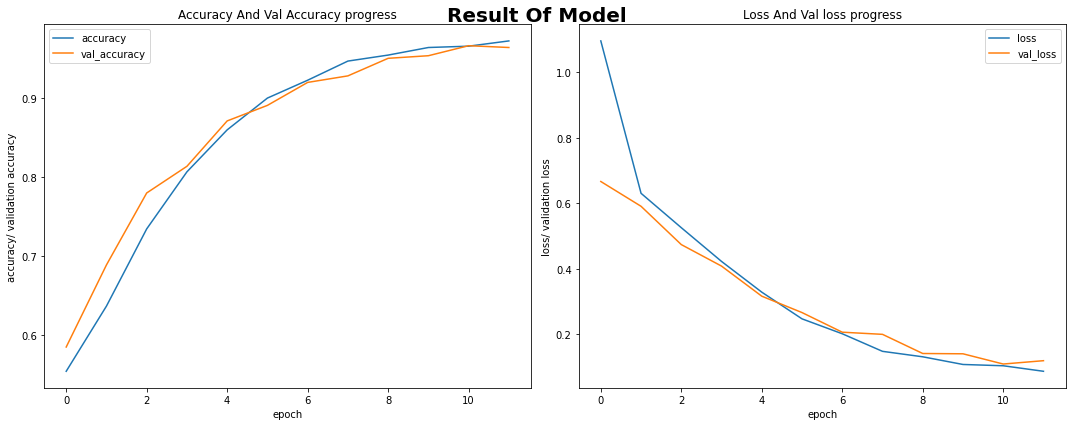

In [ ]:

def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(hist.history['accuracy'],hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss'])

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred.shape

(8784, 1)

In [ ]:
y_pred

array([[4.0461760e-02],
       [3.3048126e-01],
       [1.0135664e-06],
       ...,
       [3.0140176e-02],
       [9.9874783e-01],
       [6.9815713e-01]], dtype=float32)

In [ ]:
model.save('Mias_Mammography_CNN.h5')

In [ ]:
!pip install --upgrade tf-keras-vis tensorflow matplotlib

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
     |████████████████████████████████| 11.6MB 9.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('Mias_Mammography_CNN.h5')

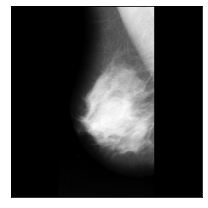

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img

image_titles = ['Number']

img1 = load_img('mdb001.pgm', target_size=(224, 224))
img1 = cv2.cvtColor(np.float32(img1), cv2.COLOR_BGR2GRAY)
images = np.asarray([np.array(img1)])


X = images/255

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax.imshow(images[i], cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
X = X.reshape(1,224,224,1)

In [ ]:
X.shape

(1, 224, 224, 1)

In [ ]:
def loss(output):
    return (output)

In [ ]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

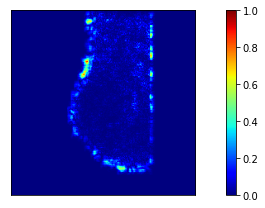

In [ ]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize


saliency = Saliency(model, model_modifier=model_modifier, clone=False)

saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax.imshow(saliency_map[0], cmap='jet')
    f.colorbar(cm.ScalarMappable(cmap='jet'), ax=ax)
plt.tight_layout()
plt.show()

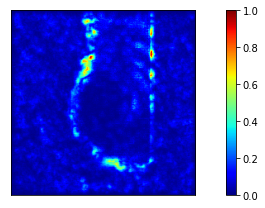

In [ ]:
saliency = Saliency(model, model_modifier=model_modifier, clone=False)


saliency_map = saliency(loss, X, smooth_samples=20, smooth_noise=0.20) 
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax.imshow(saliency_map[0], cmap='jet')
    f.colorbar(cm.ScalarMappable(cmap='jet'), ax=ax)
plt.tight_layout()
plt.show()

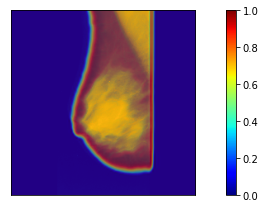

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam


gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)


cam = gradcam(loss,
              X,
              penultimate_layer=-1, 
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax.imshow(images[0])
    ax.imshow(heatmap, cmap='jet', alpha=0.5) 
    f.colorbar(cm.ScalarMappable(cmap='jet'), ax=ax)
plt.tight_layout()
plt.show()

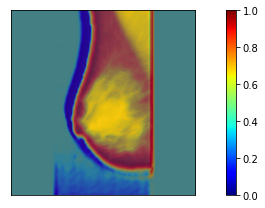

In [ ]:
from tf_keras_vis.gradcam import GradcamPlusPlus


gradcam = GradcamPlusPlus(model, model_modifier, clone=False)


cam = gradcam(loss, X, penultimate_layer=-1)
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax.imshow(images[0])
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    f.colorbar(cm.ScalarMappable(cmap='jet'), ax=ax)
plt.tight_layout()
plt.show()